# Práctica 4: Procesamiento del Lenguaje Natural

__Fecha de entrega: 14 de mayo de 2024__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

__GRUPO: 11__

Alejandro Barrachina Argudo

Jaime Benedí Galdeano

In [1]:
RANDOM_STATE = 1234

# 1) Carga del conjunto de datos

El fichero `spam.csv` contiene mensajes SMS etiquetados como spam or ham (legítimo).

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 60% para entrenamiento, 20% para validación y el 20% restante para test. Comprueba que la distribución de los ejemplos en las particiones es similar. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

Cargamos los datos del fichero csv. En un primer vistazo, observamos que el fichero esta separado en pares de elementos:

- Etiqueta: puede ser 'ham' o 'spam'.
- Contenido: una cadena de caractéres.

In [3]:
csv_data = 'spam.csv'
data = pd.read_csv(csv_data, encoding='latin-1')

Definimos una función que se encarga de procesar y simplificar el contenido de los correos. El objetivo es descartar todo aquel caracter que no pertenezca a una palabra real del inglés y tener clasificadas las palabras existentes. Palabras acentuadas, símbolos ajenos al alfabeto, código HTML...

Dentro del contexto del procesamiento del lenguaje natural, este es el proceso de tokenización de la información. Facilitará el análisis y manipulación de cara al resto de la práctica.

Concretamente, realizamos los siguientes pasos:
- Eliminamos caractéres especiales (dentro del inglés).
- Eliminamos saltos de línea y espacios en blanco.
- Transformamos toda letra a su versión minúscula.
- Esquematizamos los documentos en base a las palabras finales.

Dado que procesamos tantos documentos y queremos guardar la información en memoria, vectorizamos la operación para conseguir un extra de eficiencia en tiempo.


In [4]:
import nltk
import numpy as np

wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
def preprocess_data(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

vec_preprocess_data = np.vectorize(preprocess_data)

data['v2'] = vec_preprocess_data(data['v2'])
spam = data[data['v1'] == 'spam']
ham = data[data['v1'] == 'ham']

[nltk_data] Downloading package stopwords to /home/_alk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Aquí observamos ejemplos de como quedan los correos:

In [5]:
spam.iloc[0]['v2']

'free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply overs'

In [6]:
ham.iloc[0]['v2']

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

### Muestras a usar en nuestro modelo
Como utilizaremos validación cruzada, tenemos que dividir los datos en 'entrenamiento', 'test' y 'validación cruzada'.
Respecto al total de los datos disponibles, aplicamos el siguiente repartos de los datos:

- 60% para entrenamiento.
- 20% para prueba.
- 20% para validación.

Eso hace que tengamos que realizar una primera división 60-40, y de ese 40%, la mitad para prueba y la otra para validación

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['v2'], data['v1'], test_size=0.4, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)

Mostramos las frecuencias de contenido que sabemos que es spam y que no

#### Distribución de los datos de entrenamiento

<Axes: title={'center': 'Training set'}, ylabel='count'>

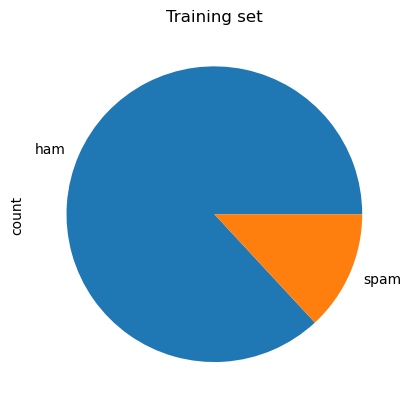

In [8]:
y_train.value_counts().plot(kind='pie', title='Training set')

#### Distribución de los datos de prueba

<Axes: title={'center': 'Test set'}, ylabel='count'>

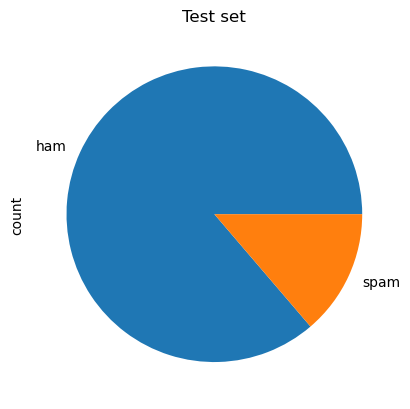

In [9]:
y_test.value_counts().plot(kind='pie', title='Test set')

#### Distribución de los datos de validación

<Axes: title={'center': 'Validation set'}, ylabel='count'>

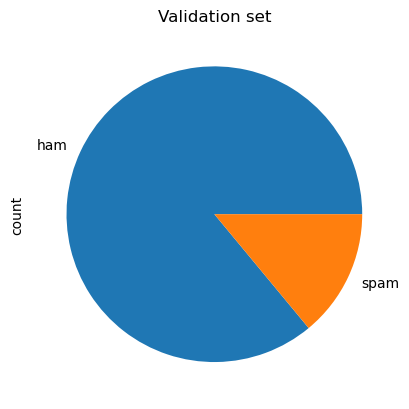

In [10]:
y_val.value_counts().plot(kind='pie', title='Validation set')

Observamos en todos los casos distribuciones muy similares. Esto es buena señal, puesto que hace más probable que toda estimación realizadad en alguna de las muestras se cumpla en las demás. En otras palabras, las muestras elegidas son representativas.

### Proceso de conteo
Iniciamos usando las herramientas de conteo ofrecidas por el módulo de collections para contar los elementos que detecta como palabras. Por ello realizaremos cuentas sobre los correos con las stopwords y sin ellas.

In [11]:
# Contamos las palabras que hay en el conjunto de datos
from collections import Counter

count_vectorizer_with_stopwords = Counter()
count_vectorizer_without_stopwords = Counter()
count_vectorizer_with_stopwords.update(' '.join(data['v2']).split())
count_vectorizer_without_stopwords.update(' '.join(data['v2']).split())

Obviamente, para aquellas cuentas donde no contemos las stopwords, las suprimimos del contador.

In [12]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

for word in stopwords:
    count_vectorizer_without_stopwords.pop(word, None)


[nltk_data] Downloading package stopwords to /home/_alk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Conteo incluyendo Stopwords

In [13]:
count_vectorizer_list = [(c,v) for (c,v) in count_vectorizer_with_stopwords.items() if len(c) > 3] 
print(len(count_vectorizer_list))
count_vectorizer_list.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_list

7436


[('call', 579),
 ('dont', 290),
 ('free', 278),
 ('ltgt', 276),
 ('know', 257),
 ('like', 242),
 ('good', 234),
 ('come', 226),
 ('time', 208),
 ('love', 195),
 ('want', 192),
 ('send', 190),
 ('text', 189),
 ('going', 171),
 ('need', 166),
 ('home', 162),
 ('sorry', 156),
 ('still', 153),
 ('stop', 153),
 ('back', 152),
 ('reply', 144),
 ('today', 141),
 ('mobile', 139),
 ('tell', 137),
 ('well', 134),
 ('later', 134),
 ('think', 132),
 ('please', 130),
 ('take', 126),
 ('phone', 126),
 ('cant', 125),
 ('week', 116),
 ('claim', 113),
 ('much', 113),
 ('night', 113),
 ('dear', 113),
 ('great', 111),
 ('happy', 106),
 ('hope', 103),
 ('make', 101),
 ('thats', 101),
 ('give', 100),
 ('work', 99),
 ('number', 94),
 ('prize', 92),
 ('right', 92),
 ('already', 90),
 ('tomorrow', 90),
 ('really', 86),
 ('yeah', 86),
 ('said', 86),
 ('message', 83),
 ('didnt', 83),
 ('meet', 78),
 ('babe', 78),
 ('last', 78),
 ('morning', 77),
 ('life', 77),
 ('miss', 76),
 ('thanks', 76),
 ('would', 76),
 ('

Observamos que reconoce un total de 7436. Siendo la más repetida 'call'.

#### Conteo excluyendo stopwords

In [14]:
count_vectorizer_list = [(c,v) for (c,v) in count_vectorizer_without_stopwords.items() if len(c) > 3] 
print(len(count_vectorizer_list))
count_vectorizer_list.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_list

7436


[('call', 579),
 ('dont', 290),
 ('free', 278),
 ('ltgt', 276),
 ('know', 257),
 ('like', 242),
 ('good', 234),
 ('come', 226),
 ('time', 208),
 ('love', 195),
 ('want', 192),
 ('send', 190),
 ('text', 189),
 ('going', 171),
 ('need', 166),
 ('home', 162),
 ('sorry', 156),
 ('still', 153),
 ('stop', 153),
 ('back', 152),
 ('reply', 144),
 ('today', 141),
 ('mobile', 139),
 ('tell', 137),
 ('well', 134),
 ('later', 134),
 ('think', 132),
 ('please', 130),
 ('take', 126),
 ('phone', 126),
 ('cant', 125),
 ('week', 116),
 ('claim', 113),
 ('much', 113),
 ('night', 113),
 ('dear', 113),
 ('great', 111),
 ('happy', 106),
 ('hope', 103),
 ('make', 101),
 ('thats', 101),
 ('give', 100),
 ('work', 99),
 ('number', 94),
 ('prize', 92),
 ('right', 92),
 ('already', 90),
 ('tomorrow', 90),
 ('really', 86),
 ('yeah', 86),
 ('said', 86),
 ('message', 83),
 ('didnt', 83),
 ('meet', 78),
 ('babe', 78),
 ('last', 78),
 ('morning', 77),
 ('life', 77),
 ('miss', 76),
 ('thanks', 76),
 ('would', 76),
 ('

Observamos que reconoce un total de 7436. Siendo la más repetida 'call'.

Ambos conjuntos tienen 7436. Tienen una misma distribución de palabras y apariciones.

#### Conteo de palabras en spam y ham

Creamos contadores para ambas poblaciones a analizar.

In [15]:
count_vectorizer_train_spam = Counter()
count_vectorizer_train_ham = Counter()
count_vectorizer_train_spam.update(' '.join(X_train[y_train == 'spam']).split())
count_vectorizer_train_ham.update(' '.join(X_train[y_train == 'ham']).split())

Filtramos las stopwords para ambas poblaciones.

In [16]:
for words in stopwords:
    count_vectorizer_train_spam.pop(words, None)
    count_vectorizer_train_ham.pop(words, None)

Esta sería la distribución de palabras dentro del conjunto de mensajes considerados spam.

In [17]:
count_vectorizer_train_spam = [(c,v)for (c,v) in count_vectorizer_train_spam.items() if len(c) > 3]
count_vectorizer_train_spam.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_train_spam

[('call', 213),
 ('free', 126),
 ('mobile', 79),
 ('text', 73),
 ('stop', 71),
 ('reply', 67),
 ('claim', 63),
 ('prize', 51),
 ('send', 42),
 ('service', 42),
 ('contact', 41),
 ('nokia', 40),
 ('cash', 39),
 ('urgent', 38),
 ('guaranteed', 32),
 ('phone', 31),
 ('please', 31),
 ('customer', 29),
 ('chat', 28),
 ('awarded', 25),
 ('line', 25),
 ('mins', 25),
 ('landline', 25),
 ('week', 25),
 ('camera', 23),
 ('tone', 23),
 ('live', 22),
 ('video', 21),
 ('message', 21),
 ('draw', 20),
 ('shows', 20),
 ('holiday', 20),
 ('number', 20),
 ('latest', 19),
 ('want', 18),
 ('receive', 18),
 ('offer', 17),
 ('award', 17),
 ('network', 17),
 ('attempt', 16),
 ('collection', 16),
 ('code', 16),
 ('ringtone', 16),
 ('every', 16),
 ('delivery', 15),
 ('bonus', 15),
 ('chance', 14),
 ('tones', 14),
 ('orange', 14),
 ('club', 14),
 ('back', 14),
 ('dating', 14),
 ('cost', 14),
 ('gift', 13),
 ('weekly', 13),
 ('find', 13),
 ('time', 13),
 ('apply', 13),
 ('land', 13),
 ('tried', 13),
 ('valid', 1

Esta sería la distribución de palabras que aparecen en los mensajes no considerados spam (ham).

In [18]:
count_vectorizer_train_ham = [(c,v)for (c,v) in count_vectorizer_train_ham.items() if len(c) > 3]
count_vectorizer_train_ham.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_train_ham

[('ltgt', 179),
 ('dont', 157),
 ('know', 148),
 ('call', 146),
 ('like', 135),
 ('come', 134),
 ('good', 125),
 ('time', 110),
 ('love', 109),
 ('going', 108),
 ('home', 98),
 ('want', 97),
 ('sorry', 96),
 ('need', 91),
 ('tell', 86),
 ('send', 85),
 ('later', 85),
 ('still', 83),
 ('well', 77),
 ('think', 76),
 ('back', 75),
 ('take', 74),
 ('today', 70),
 ('much', 67),
 ('yeah', 64),
 ('thats', 64),
 ('cant', 64),
 ('great', 61),
 ('night', 60),
 ('hope', 55),
 ('give', 54),
 ('already', 53),
 ('said', 53),
 ('work', 52),
 ('dear', 51),
 ('make', 50),
 ('happy', 49),
 ('please', 49),
 ('didnt', 48),
 ('right', 48),
 ('morning', 47),
 ('text', 46),
 ('phone', 46),
 ('life', 46),
 ('sure', 45),
 ('meet', 44),
 ('miss', 44),
 ('really', 43),
 ('something', 43),
 ('also', 42),
 ('would', 42),
 ('last', 42),
 ('friends', 42),
 ('soon', 41),
 ('went', 41),
 ('around', 41),
 ('free', 41),
 ('tomorrow', 40),
 ('pick', 40),
 ('wait', 40),
 ('number', 40),
 ('sent', 39),
 ('many', 38),
 ('ni

# 2) Representación como bolsa de palabras

Elige justificadamente una representación de bolsa de palabras y aplícala.
Muestra un ejemplo antes y después de aplicar la representación. Explica los cambios.

```CountVectorizer``` nos genera una bolsa de palabras en la que va a clasificar cada palabra como un _token_ y va a contar cada ocurrencia de esa palabra en cada documento.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_matrix = cv.fit_transform(X_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
vocab = cv.get_feature_names_out()

pd.DataFrame(cv_matrix, columns=vocab)

,aa,aaniye,aathilove,aathiwhere,ab,abdomen,abeg,aberdeen,abi,ability,...,zac,zealand,zed,zf,zindgi,zoe,zoom,zouk,zs,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Tras esta trasformación nos quedamos con una matriz de _tokens_ y su número de repeticiones en distintos documentos. Esto nos puede simplificar el uso de redes neuronales y métodos de aprendizaje clásicos ya que nos transforma valores cualitativos como pueden ser las frases en un _input_ cuantitativo eficiente para operaciones matemáticas.

Podemos ver aquí la transformación de un texto primero en su formato original y ya formateado y después transformado por ```CountVectorizer```

In [21]:
X_train.iloc[27]

'mmm yummy babe nice jolt suzy'

In [22]:
cv_matrix[27]

array([0, 0, 0, ..., 0, 0, 0])

_TF-IDF_ nos permite ver el peso de una palabra frente a la totalidad de documentos, no solo su repetición en un solo documento

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer()
tv_matrix = tv.fit_transform(X_train)
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,aa,aaniye,aathilove,aathiwhere,ab,abdomen,abeg,aberdeen,abi,ability,...,zac,zealand,zed,zf,zindgi,zoe,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con el siguiente código vamos a poder ver la similitud que hay entre dos palabras distintas frente a su presencia en textos.

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix) 
similarity_df


,0,1,2,3,4,5,6,7,8,9,...,3333,3334,3335,3336,3337,3338,3339,3340,3341,3342
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.064652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.119640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.164103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3339,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3340,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3341,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Para un problema como es el reconocimiento de spam en correos y viendo que algunos correos tienen un conteo de palabras muy limitado, hemos decidido que la mejor representación para este problema es usar _TF-IDF_, ya que nos aporta una mayor cantidad de conocimiento frente al problema general.

Creemos esto porque se puede dar el caso de que un correo que debería catalogarse como spam tenga pocas repeticiones de esas palabras que consideramos importantes para la clasificación, pero al saber su peso relativo el algoritmo puede clasificarlas como importantes.

# 3) Aplica 3 algoritmos de aprendizaje automático para resolver la tarea

Justifica porqué los has elegido.
Ajusta los modelos respecto a un hiperparámetro que consideres oportuno. Justifica tu elección.
Explica los resultados obtenidos.

In [25]:
from sklearn import tree
import numpy as np
train_preprocessed = tv.transform(X_train)
test_preprocessed = tv.transform(X_test)
cv_preprocessed = tv.transform(X_val)

# Creamos el clasificador con los valores por defecto
tree_classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, splitter='best', max_depth=10)
tree_classifier.fit(train_preprocessed, y_train)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)
tree_cv_predictions = tree_classifier.predict(cv_preprocessed)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))
print("Árbol, porcentaje de aciertos en validación:", np.mean(tree_cv_predictions == y_val))

Árbol, porcentaje de aciertos en entrenamiento: 0.9817529165420281
Árbol, porcentaje de aciertos en test: 0.9470377019748654
Árbol, porcentaje de aciertos en validación: 0.9452914798206278


En ```DecisionTreeClassifier``` hemos escogido el parametro de _max\_depth_ como 10 para evitar un sobre entrenamiento y porque los datos de test y validación no cambian demasiado si se sube a 15 o 20 o si se deja en el por defecto (sin máximo), solo consiguiendo un sobre entrenamiento en train.

In [26]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier(weights='distance', n_jobs=-1)
knn_classifier.fit(train_preprocessed, y_train)

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)
knn_cv_predictions = knn_classifier.predict(cv_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == y_train))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == y_test))
print("k-NN, porcentaje de aciertos en validación:", np.mean(knn_cv_predictions == y_val))

k-NN, porcentaje de aciertos en entrenamiento: 1.0
k-NN, porcentaje de aciertos en test: 0.921903052064632
k-NN, porcentaje de aciertos en validación: 0.9273542600896861


En ```KNeighborsClassifier```, ponemos el valor _weights_ a _distance_ ya que aunque sobre entrena en train, nos da unos valores de un 8% superiores a los de _uniform_. Ponemos _n\_jobs_  a -1 dado que esto implica que se usará todo el procesador para paralelización, aunque en este problema eso no genera inconvenientes porque tarda poco en ejecutarse.

In [27]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)

mnb_classifier.fit(train_preprocessed, y_train)

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)
mnb_cv_predictions = mnb_classifier.predict(cv_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == y_test))
print("Multinomial Naive Bayes, porcentaje de aciertos en validación:", np.mean(mnb_cv_predictions == y_val))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9970086748429554
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9802513464991023
Multinomial Naive Bayes, porcentaje de aciertos en validación: 0.9766816143497757


En ```MultinomialNB``` utilizamos un $\alpha$ de 0.1 para evitar sobre entrenamientos y ponemos _fit\_prior_ a ```True``` y _class\_prior_ a ```None```, lo cual saca una probabilidad de clase del conjunto de entrenamiento y la aplica al resto del algoritmo. Excepto por el valor de $\alpha$, esto es casi el comportamiento estándar de ```MultinomialNB```.

El mejor parece Multinomial Naive Bayes ya que no sobreentrena (por poco) en train y da los mejores valores en test y cv

# 4) Construye redes neuronales con Keras con distintas maneras de usar word embeddings

Justifica tus decisiones y explica los resultados obtenidos.

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_words = 1500
max_comment_length = 20

csv_data = 'spam.csv'
df = pd.read_csv(csv_data, encoding='latin-1')

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.v2)

sequences = tokenizer.texts_to_sequences(df.v2)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_words = len(word_index)

data = pad_sequences(sequences, maxlen=max_comment_length)

2024-05-13 18:39:55.236990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 8916 unique tokens.


La función _fit\_on\_texts_ va a actualizar el vocabulario interno basándose en la frecuencia de cada palabra.
Tras esto, _texts\_to\_sequences_ transforma cada texto en una secuencia de enteros a traves del diccionario de indices del vocabulario.
_pad\_sequences_ nos permite que todas las secuencias tengan el mismo tamaño para poder hacer una red neuronal con el máximo tamaño de frase como _input layer_

In [29]:
labels = df.v1.to_numpy()
def transform_label(x):
    return 1 if x == 'spam' else 0
labels = np.array([transform_label(x) for x in labels])

Con esto transformamos nuestro clasificador de _spam_ y _ham_ a 0 o 1

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle=True, test_size=0.4, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5, random_state=RANDOM_STATE)

<Axes: title={'center': 'Train set'}, ylabel='count'>

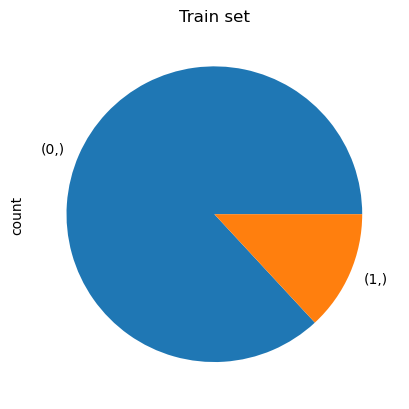

In [31]:
pd.DataFrame(y_train).value_counts().plot(kind='pie', title='Train set')

<Axes: title={'center': 'Test set'}, ylabel='count'>

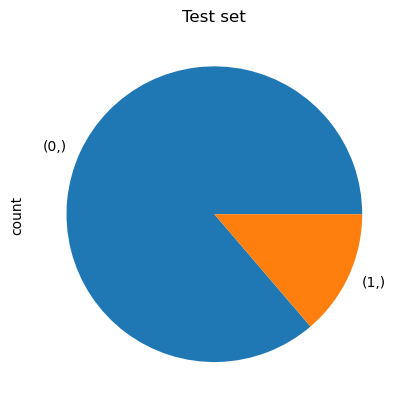

In [32]:
pd.DataFrame(y_test).value_counts().plot(kind='pie', title='Test set')

<Axes: title={'center': 'Validation set'}, ylabel='count'>

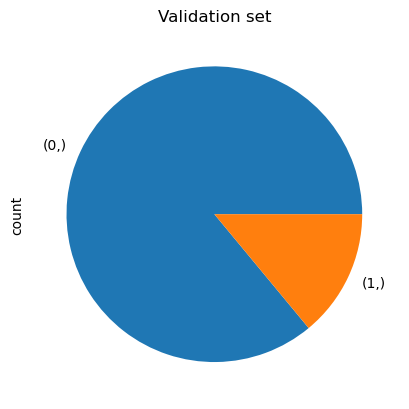

In [33]:
pd.DataFrame(y_val).value_counts().plot(kind='pie', title='Validation set')

In [34]:

embedding_dim = 50

Aquí tenemos un ejemplo de como quedaría la primera frase de nuestro conjunto de entrenamiento y su etiqueta.

In [35]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 500  77
 115 132]


In [36]:
print(y_train[0])

0


In [37]:
# MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model1 = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs


model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
# After the Embedding layer, our activations have shape `(max_words, max_comment_length, embedding_dim)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(max_words, max_comment_length * embedding_dim)`

model1.add(Flatten())

# We add the classifier on top
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))

score1 = model1.evaluate(X_test, y_test)

print("Accuracy: %.2f%%" % (score1[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            445800    
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 446,801
Trainable params: 446,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2024-05-13 18:39:57.322484: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


105/105 [==============================] - 1s 6ms/step - loss: 0.3699 - accuracy: 0.9079 - val_loss: 0.1912 - val_accuracy: 0.9507
Epoch 2/20
105/105 [==============================] - 0s 5ms/step - loss: 0.1272 - accuracy: 0.9650 - val_loss: 0.0963 - val_accuracy: 0.9722
Epoch 3/20
105/105 [==============================] - 0s 5ms/step - loss: 0.0647 - accuracy: 0.9827 - val_loss: 0.0620 - val_accuracy: 0.9812
Epoch 4/20
105/105 [==============================] - 1s 5ms/step - loss: 0.0415 - accuracy: 0.9895 - val_loss: 0.0498 - val_accuracy: 0.9874
Epoch 5/20
105/105 [==============================] - 1s 5ms/step - loss: 0.0290 - accuracy: 0.9937 - val_loss: 0.0455 - val_accuracy: 0.9883
Epoch 6/20
105/105 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9955 - val_loss: 0.0422 - val_accuracy: 0.9901
Epoch 7/20
105/105 [==============================] - 1s 5ms/step - loss: 0.0166 - accuracy: 0.9967 - val_loss: 0.0416 - val_accuracy: 0.9901
Epoch 8/20
105/10

En el modelo sin Embedings pre-entrenados conseguimos una  precisión del 98%

Ahora vamos a utilizar los embeddings dados por el archivo glove.6B.50d.txt

In [38]:
import os
import numpy as np

glove_dir = './'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Este modelo será igual que el anterior pero le añadiremos los pesos de los embeddings mas tarde.

In [40]:
# MODELO 2. EMBEDDINGS PRE-ENTRENADOS CONGELADOS

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

Aquí añadimos los pesos de los embeddings a mano y le decimos que no los sobreescriba, haciendo así que permanezcan congelados

In [41]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 50)            445800    
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 446,801
Trainable params: 1,001
Non-trainable params: 445,800
_________________________________________________________________


In [42]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))

score2 = model2.evaluate(X_test, y_test)

print("Accuracy: %.2f%%" % (score2[1]*100))

Epoch 1/20
105/105 [==============================] - 1s 3ms/step - loss: 0.3029 - accuracy: 0.9010 - val_loss: 0.2018 - val_accuracy: 0.9426
Epoch 2/20
105/105 [==============================] - 0s 1ms/step - loss: 0.1615 - accuracy: 0.9477 - val_loss: 0.1582 - val_accuracy: 0.9543
Epoch 3/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1285 - accuracy: 0.9617 - val_loss: 0.1386 - val_accuracy: 0.9632
Epoch 4/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1102 - accuracy: 0.9689 - val_loss: 0.1298 - val_accuracy: 0.9641
Epoch 5/20
105/105 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.9719 - val_loss: 0.1203 - val_accuracy: 0.9650
Epoch 6/20
105/105 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9758 - val_loss: 0.1165 - val_accuracy: 0.9668
Epoch 7/20
105/105 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.9773 - val_loss: 0.1104 - val_accuracy: 0.9668
Epoch 

Este modelo nos da una precisión del 96%, por lo que podemos deducir que usar estos embeddigns sin permitir un aprendizaje sobre los mismos no es muy útil.

En el siguiente modelo pondremos los pesos de los embeddings a mano una vez más, pero esta vez permitiremos un entrenamiento de esa capa para intentar mejorar los resultados

In [43]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model3.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))

score3 = model3.evaluate(X_test, y_test)

print("Accuracy: %.2f%%" % (score3[1]*100))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 50)            445800    
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 446,801
Trainable params: 446,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
105/105 [==============================] - 1s 6ms/step - loss: 0.2657 - accuracy: 0.9103 - val_loss: 0.1584 - val_accuracy: 0.9543
Epoch 2/20
105/105 [==============================] - 0s 5ms/step - loss: 0.1188 - accuracy: 0.9644 - val_loss: 0.1126 - val_accuracy: 0.9623
Epoch 3/20
105/105 [========

Con unos embeddings preentrenados y con aprendizaje en los mismos conseguimos un acierto del 98%, aunque si vemos el _log_ de la ejecución podemos ver que en un momento dado se llega a un valor cercano al 99% en validación.

In [44]:
print("Sin word embeddings pre-entrenados")
print("Accuracy: %.2f%%" % (score1[1]*100))
print("Con word embeddings pre-entrenados congelados")
print("Accuracy: %.2f%%" % (score2[1]*100))
print("Con word embeddings pre-entrenados sin congelar")
print("Accuracy: %.2f%%" % (score3[1]*100))

Sin word embeddings pre-entrenados
Accuracy: 98.29%
Con word embeddings pre-entrenados congelados
Accuracy: 96.86%
Con word embeddings pre-entrenados sin congelar
Accuracy: 97.94%


Tras este resumen, vemos que los valores sin word embeddings y con word embeddings sin congelar son muy muy similares, mientras que los preentrenados y congelados nos dan un valor menor.

# 5) Aplica los modelos construidos a los datos de test y compáralos.

Calcula las métricas de recall, precisión y f1.
Discute cual es el mejor modelo y cual es peor y porqué.

Esta bonita función nos va a permitir ver de manera visual el acierto y equivocación por clase de cada clasificador.

In [45]:
def plot_confusion_matrix(y: np.ndarray, p: np.ndarray, tags) -> None:
    """Plots the confusion matrix for a given prediction.

    Args:
        y (np.ndarray): expected values
        p (np.ndarray): predicted values
        filename (str): file to store the plot
    """
    fig, ax = plt.subplots()
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_xticks(np.arange(0,tags))
    ax.set_yticks(np.arange(0,tags))
    ax.set_ylabel("True")
    cm = np.zeros((tags, tags))
    for i in range(len(y)):
        cm[y[i] - 1][p[i] - 1] += 1
    cax = ax.matshow(cm, cmap='Reds')
    ax.set_xticks(np.arange(0, tags))
    ax.set_yticks(np.arange(0, tags))
    ax.set_yticks(np.arange(0.5, tags + 0.5), minor='True')
    ax.set_xticks(np.arange(0.5, tags + 0.5), minor='True')
    plt.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.5)
    fig.colorbar(cax)
    for (i, j), z in np.ndenumerate(cm):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on intensity of background
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=8, color=text_color)
    plt.show()

Primero vamos a ver los resultados de ```DecisionTreeClassifier```

              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       961
        spam       0.92      0.67      0.78       153

    accuracy                           0.95      1114
   macro avg       0.93      0.83      0.87      1114
weighted avg       0.95      0.95      0.94      1114



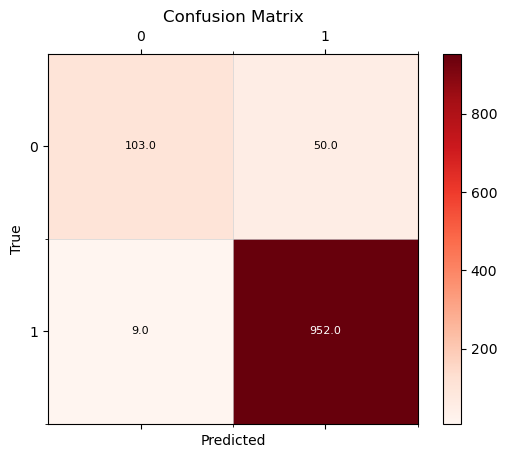

In [48]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions_tree = [1 if x == 'spam' else 0 for x in tree_test_predictions]
print(classification_report(
    y_test, predictions_tree, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions_tree, len(target_names))

Veamos ahora las estadísticas de ```KNeighborClassifier```

              precision    recall  f1-score   support

         ham       0.92      1.00      0.96       961
        spam       1.00      0.43      0.60       153

    accuracy                           0.92      1114
   macro avg       0.96      0.72      0.78      1114
weighted avg       0.93      0.92      0.91      1114



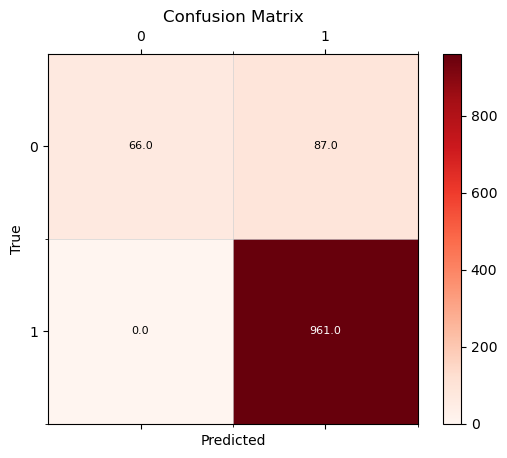

In [49]:
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions_knn = [1 if x == 'spam' else 0 for x in knn_test_predictions]
print(classification_report(
    y_test, predictions_knn, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions_knn, len(target_names))

Continuamos con el mejor resultado de los clasificadores iniciales, ```MultinomialNB```

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       961
        spam       0.97      0.88      0.92       153

    accuracy                           0.98      1114
   macro avg       0.98      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



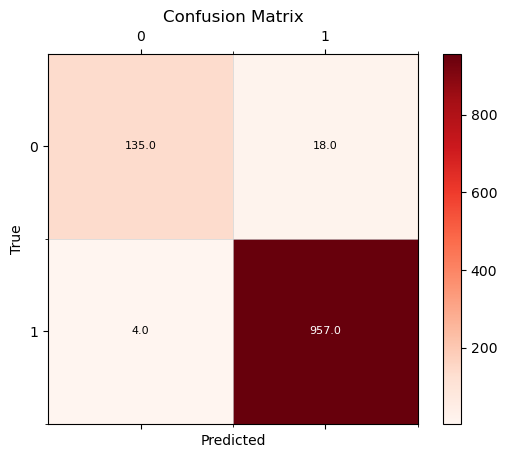

In [50]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions_mnb = [1 if x == 'spam' else 0 for x in mnb_test_predictions]
print(classification_report(
    y_test, predictions_mnb, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions_mnb, len(target_names))

Creamos una función auxiliar que nos permita clasificar entre 0 y 1 las predicciones hechas con los modelos de Keras en base a una probabilidad de 0.5

In [52]:
def predict_binary_with_sequential_model(model, input_data, threshold=0.5):
    """
    Predicts the binary output labels for input data using a TensorFlow sequential model.

    Args:
    - model: A TensorFlow sequential model.
    - input_data: Input data for prediction.
    - threshold: Threshold for binary classification (default is 0.5).

    Returns:
    - predictions: Binary predictions.
    """
    input_data = np.array(input_data)
    
    predictions_proba = model.predict(input_data)
    
    predictions_binary = (predictions_proba > threshold).astype(int)
    
    return predictions_binary

Empezamos con ```model1```, red neuronal sin word embeddings preentrenados

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       961
        spam       0.99      0.88      0.93       153

    accuracy                           0.98      1114
   macro avg       0.99      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



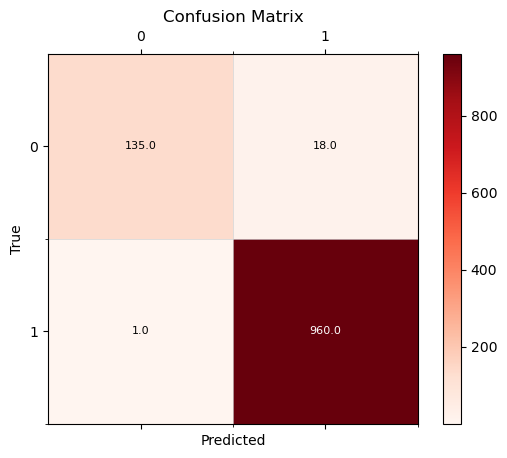

In [53]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones

predictions_m1 = predict_binary_with_sequential_model(model1, X_test)
print(classification_report(
    y_test, predictions_m1, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions_m1, len(target_names))

Ahora es el turno de ```model2```, modelo con word embeddings preentrenados y congelados

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       961
        spam       0.95      0.81      0.88       153

    accuracy                           0.97      1114
   macro avg       0.96      0.90      0.93      1114
weighted avg       0.97      0.97      0.97      1114



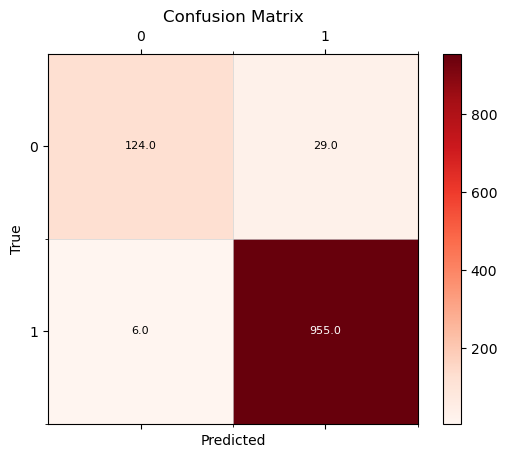

In [54]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions_m2 = predict_binary_with_sequential_model(model2, X_test)
print(classification_report(
    y_test, predictions_m2, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions_m2, len(target_names))

Terminamos esta comparativa con ```model3```, con word embeddings preentrenados y sin congelar

35/35 [==============================] - 0s 981us/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       961
        spam       0.99      0.86      0.92       153

    accuracy                           0.98      1114
   macro avg       0.98      0.93      0.95      1114
weighted avg       0.98      0.98      0.98      1114



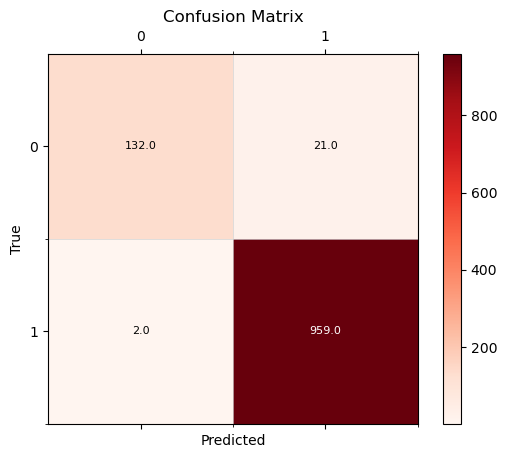

In [55]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions_m3 = predict_binary_with_sequential_model(model3, X_test)
print(classification_report(
    y_test, predictions_m3, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions_m3, len(target_names))

In [69]:
from sklearn.metrics import precision_recall_fscore_support
def compare_metrics(predictions: list[np.ndarray], y_test):
    recalls = []
    precisions = []
    f1_scores = []
    supports = []

    for prediction in predictions:
        precision, recall, f1_score, support =  precision_recall_fscore_support(y_test, prediction, average='binary')
        recalls.append(recall)
        precisions.append(precision)
        f1_scores.append(f1_score)
        supports.append(support)
    df = pd.DataFrame({
        'Recall': recalls,
        'Precision': precisions,
        'F1 Score': f1_scores
    })
    df.index = ['Decision Tree', 'k-NN', 'Multinomial Naive Bayes', 'Sequential Model 1', 'Sequential Model 2', 'Sequential Model 3']

    return df

In [70]:
df = compare_metrics([predictions_tree, predictions_knn, predictions_mnb, predictions_m1, predictions_m2, predictions_m3], y_test)

In [71]:
df

,Recall,Precision,F1 Score
Decision Tree,0.673203,0.919643,0.777358
k-NN,0.431373,1.000000,0.602740
Multinomial Naive Bayes,0.882353,0.971223,0.924658
Sequential Model 1,0.882353,0.992647,0.934256
Sequential Model 2,0.810458,0.953846,0.876325
Sequential Model 3,0.862745,0.985075,0.919861


Vamos a ver que algoritmo ha sacado el valor máximo en cada métrica

In [72]:
df.idxmax()

Recall       Multinomial Naive Bayes
Precision                       k-NN
F1 Score          Sequential Model 1
dtype: object

KNN nos presenta la mayor precisión, pero un recall desastroso y un F1 bastante bajo.

Multinomial Naive Bayes  nos presenta el mejor recall (0.2 mayor que el de sequential model 3) y un F1 bastante próximo al máximo

Sequential Model 1 nos presenta la segunda precisión más alta, la segunda recall más alta y el F1 más alto de todo el conjunto de métricas.

Viendo esta comparativa y las matrices de confusión, nos decantamos por _Sequential Model 1_ como el modelo más fiable. A parte de lo expuesto anteriormente, en las matrices de confusión vemos que clasifica ligerísimamente mejor que _Multinomial Naive Bayes_.